# X-ray tomography

In [2]:
# import libraries
import numpy as np
import odl
%matplotlib inline

## Generate data

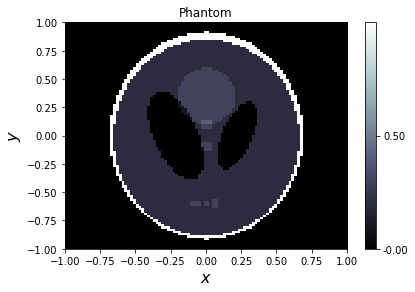

<Figure size 432x288 with 0 Axes>

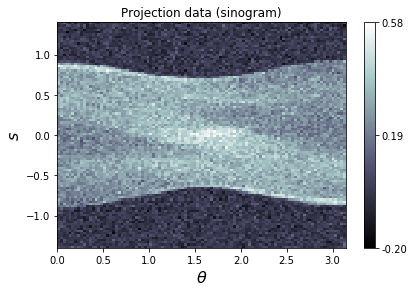

<Figure size 432x288 with 0 Axes>

In [25]:
# Reconstruction space: [-1, 1]^2 with 100 samples per dimension.
reco_space = odl.uniform_discr(min_pt=[-1, -1], max_pt=[1, 1], shape=[100, 100], dtype='float32')

# Make a parallel beam geometry with flat detector
# Angles: [0,pi], uniformly spaced, 100 samples
angle_partition = odl.uniform_partition(0, np.pi, 100)

# Detector: uniformly sampled, n = 100, min = -1.4, max = 1.4
detector_partition = odl.uniform_partition(-1.4, 1.4, 100)
geometry = odl.tomo.Parallel2dGeometry(angle_partition, detector_partition)

# Ray transform (= forward projection)
K = odl.tomo.RayTransform(reco_space, geometry)

# Create a discrete Shepp-Logan phantom (modified version)
u = odl.phantom.shepp_logan(reco_space, modified=True)

# Create noisy projection data
f = K(u) 
delta = 0.05
f_delta = f + delta*odl.phantom.white_noise(K.range)

# show phantom and sinogram
u.show(title='Phantom')
fdelta.show(title='Projection data (sinogram)');

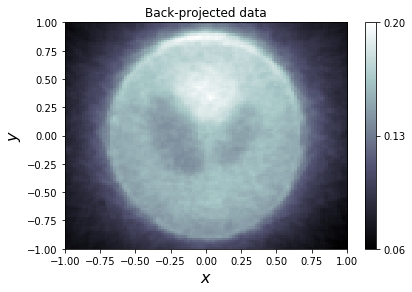

<Figure size 432x288 with 0 Axes>

|f - f_delta|/|f| =  0.378932402903857
|u - u_bp|/|u| =  0.7963408650709854


In [33]:
# Back-projection can be done by simply calling the adjoint operator on the
# projection data (or any element in the projection space).
u_bp = K.adjoint(f_delta)

# scale to optimally match the projection data
f_bp = K(u_bp)
alpha = f_delta.inner(f_bp)/f_bp.norm()**2
u_bp = alpha*u_bp

# Shows a slice of the phantom, projections, and reconstruction
u_bp.show(title='Back-projected data');

# error
print('|f - f_delta|/|f| = ',(K(u_bp)-f_delta).norm()/f.norm())
print('|u - u_bp|/|u| = ',(u-u_bp).norm()/u.norm())

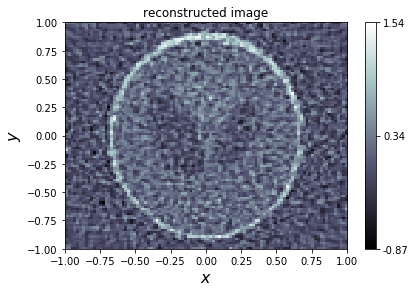

<Figure size 432x288 with 0 Axes>

|f - f_delta|/|f| =  0.17553313516238953
|u - u_cg|/|u| =  0.9556163039337556


In [34]:
# Choose a starting point
u_cg = K.domain.zero()

# Run the algorithm
odl.solvers.conjugate_gradient_normal(K, u_cg, f_delta, niter=20)

# Display images
u_cg.show(title='reconstructed image');

# error
print('|f - f_delta|/|f| = ',(K(u_cg)-f_delta).norm()/f.norm())
print('|u - u_cg|/|u| = ',(u-u_cg).norm()/u.norm())

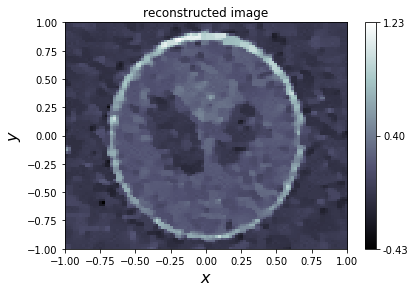

<Figure size 432x288 with 0 Axes>

|f - f_delta|/|f| =  0.20433361872997008
|u - u_tv|/|u| =  0.468257698371457


In [43]:
# --- Set up optimization problem and solve --- #

# Create data term ||Ax - b||_2^2 as composition of the squared L2 norm and the
# ray trafo translated by the data.
l2_norm = odl.solvers.L2NormSquared(K.range)
data_discrepancy = l2_norm * (K - f_delta)

# Create regularizing functional || |grad(x)| ||_1 and smooth the functional
# using the Moreau envelope.
# The parameter sigma controls the strength of the regularization.
gradient = odl.Gradient(reco_space)
l1_norm = odl.solvers.GroupL1Norm(gradient.range)
smoothed_l1 = odl.solvers.MoreauEnvelope(l1_norm, sigma=0.03)
regularizer = smoothed_l1 * gradient

# Create full objective functional
lam = 3e-4
obj_fun = data_discrepancy + lam * regularizer

# Create initial estimate of the inverse Hessian by a diagonal estimate
opnorm = odl.power_method_opnorm(K)
hessinv_estimate = odl.ScalingOperator(reco_space, 1 / opnorm ** 2)

# Pick parameters
maxiter = 30
num_store = 5  # only save some vectors (Limited memory)

# Choose a starting point
u_tv = K.domain.zero()

# Run the algorithm
odl.solvers.bfgs_method(obj_fun, u_tv, maxiter=maxiter, num_store=num_store, hessinv_estimate=hessinv_estimate)

# results
# Display images
u_tv.show(title='reconstructed image');

# error
print('|f - f_delta|/|f| = ',(K(u_tv)-f_delta).norm()/f.norm())
print('|u - u_tv|/|u| = ',(u-u_tv).norm()/u.norm())
